In [67]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing,SimpleExpSmoothing, Holt
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
from pylab import rcParams
import seaborn as sns

## Approach 2: Use Traditional statestical models

In this notebook we will discuss following models on daily sampled data.

   1. MA
   2. Simple Exponential Smoothing
   3. Holt Linear
   4. Holt-Winters
   These models are implemented using statsmodels library.
   
**Objective: Implement above models and calculate RMSE to compare reults with Approach 1.**
   1. Load previously created daily sampled data and decompose the time series
   2. Fit each model and predict test data
   3. Calculate RMSE and MAE
   4. Compare results with Approach 1

In [39]:
# Load data
data = pd.read_csv("daily_data.csv",parse_dates=[0], index_col=0)
data.head()


,Total Price
date,
2016-09-04,136.23
2016-09-05,75.06
2016-09-06,0.00
2016-09-07,0.00
2016-09-08,0.00


### Decompose time series

A series is thought to be an aggregate or combination of these four components.All series have a level and noise. The trend and seasonality components are optional.
These components combine either additively or multiplicatively.

#### Additive Model
An additive model suggests that the components are added together as follows:
	
y(t) = Level + Trend + Seasonality + Noise

An additive model is linear where changes over time are consistently made by the same amount.<br>
A linear trend is a straight line.<br>
A linear seasonality has the same frequency (width of cycles) and amplitude (height of cycles).<br>

#### Multiplicative Model
A multiplicative model suggests that the components are multiplied together as follows:

y(t) = Level * Trend * Seasonality * Noise

A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time.<br>
A nonlinear trend is a curved line.<br>
A non-linear seasonality has an increasing or decreasing frequency and/or amplitude over time.<br>

Referance: https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

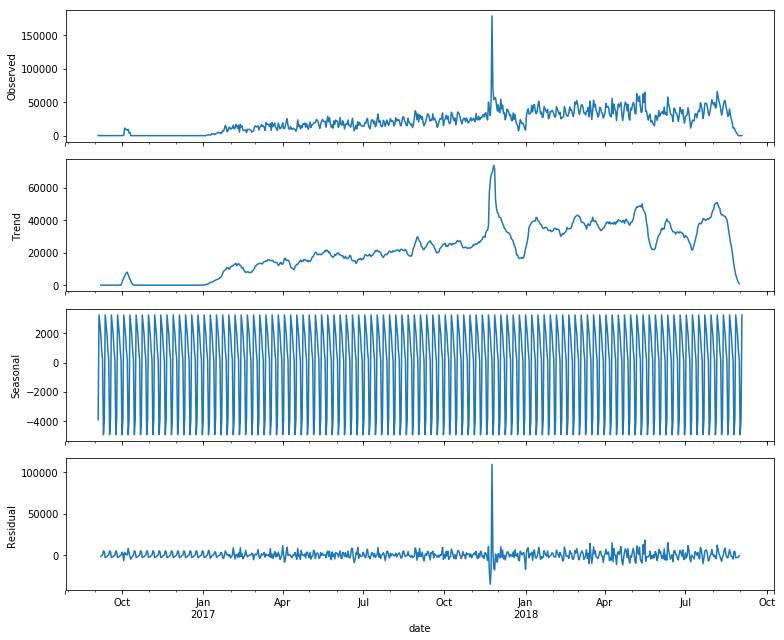

In [40]:
#Decompose time series into trend, seasonality and noise
rcParams['figure.figsize'] = 11, 9
result = sm.tsa.seasonal_decompose(data, model='additive')
result.plot()
plt.show()


In [41]:
#Print trend, seasality, residual
print(result.trend)
print(result.seasonal)
print(result.resid)
#print(result.observed)

             Total Price
date                    
2016-09-04           NaN
2016-09-05           NaN
2016-09-06           NaN
2016-09-07     30.184286
2016-09-08     10.722857
2016-09-09      0.000000
2016-09-10      0.000000
2016-09-11      0.000000
2016-09-12     20.494286
2016-09-13     20.494286
2016-09-14     20.494286
2016-09-15     20.494286
2016-09-16     20.494286
2016-09-17     20.494286
2016-09-18     20.494286
2016-09-19      0.000000
2016-09-20      0.000000
2016-09-21      0.000000
2016-09-22      0.000000
2016-09-23      0.000000
2016-09-24      0.000000
2016-09-25      0.000000
2016-09-26      0.000000
2016-09-27      0.000000
2016-09-28      0.000000
2016-09-29     15.620000
2016-09-30    100.640000
2016-10-01   1714.280000
2016-10-02   3092.271429
2016-10-03   4396.732857
...                  ...
2018-08-05  50594.058571
2018-08-06  50752.515714
2018-08-07  49333.617143
2018-08-08  47810.464286
2018-08-09  47020.132857
2018-08-10  44165.345714
2018-08-11  43190.630000


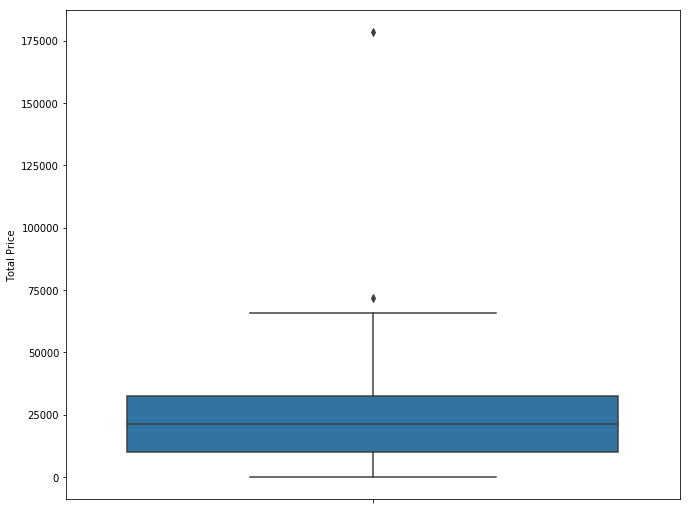

In [42]:
#Find out outliers
sns.boxplot(x=data['Total Price'],orient='v')

**Z score denotes how many standerd deviation away your sample is from the mean. Hence we remove all samples which are 3 std. deviations away from mean**

In [47]:
#Calculate Z score for all samples
z = np.abs(stats.zscore(data))


In [48]:
#Locate outliers
outliers = data[(z > 3).all(axis=1)]
outliers

,Total Price
date,
2017-11-24,178377.63
2017-11-25,71858.16


In [49]:
#Replace outliers by median value
median = data[(z < 3).all(axis=1)].median()
data.loc[data['Total Price'] > 71858, 'Total Price'] = np.nan
data.fillna(median,inplace=True)

In [50]:
median

Total Price    21074.89
dtype: float64

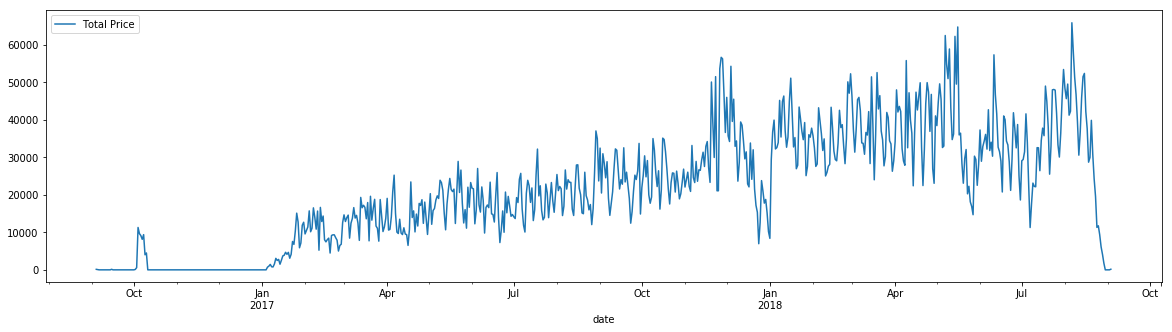

In [51]:
#Plot data again
rcParams['figure.figsize'] = 20, 5
data.plot()

**Below we can see time series clearly, there is exponential growth in trend at start but linear towards the end. 
Seasonality is not increasing exponentialy, rather it's constant. Hece we can say that our time serie is additive.**

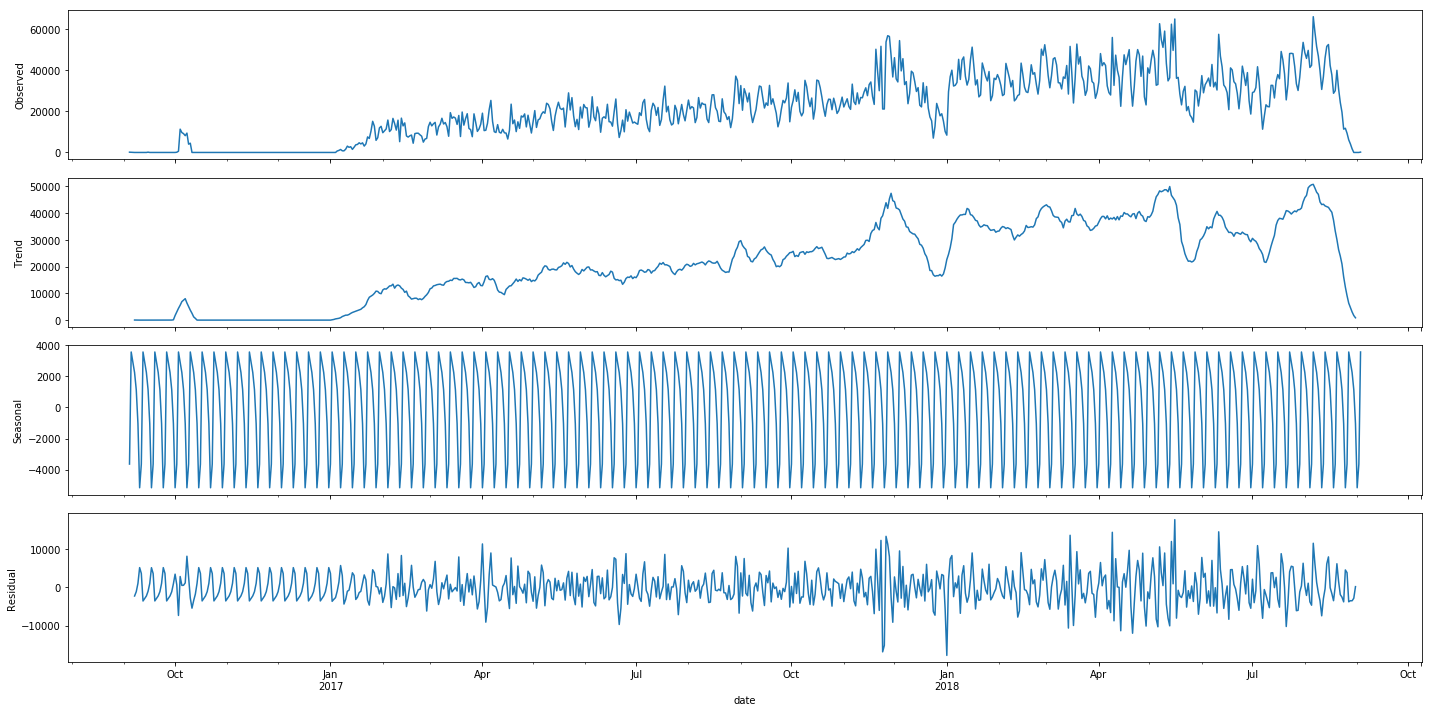

In [52]:
#Plot the data
rcParams['figure.figsize'] = 20, 10
result = sm.tsa.seasonal_decompose(data, model='additive')
result.plot()
plt.show()

In [56]:
#Train and test data
train=data[0:-100] 
test=data[-100:]

In [57]:
y_hat = test.copy()

### 1. Moving Average: 
In this method, we use the mean of the previous data. Using the prices of the initial period would highly affect the forecast for the next period. Therefore, we will take the average of the prices for last few recent time periods only.  
Such forecasting technique which uses window of time period for calculating the average is called Moving Average technique. Calculation of the moving average involves what is sometimes called a “sliding window” of size n.

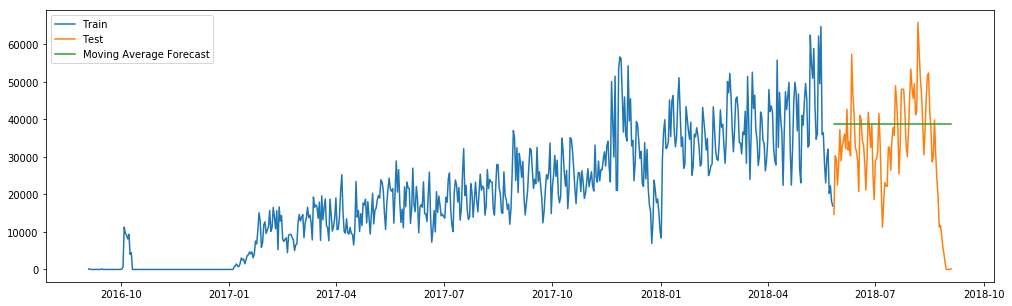

In [58]:
#Calculate MA: use last 50 data points
rcParams['figure.figsize'] = 17, 5
y_hat['moving_avg_forecast'] = train['Total Price'].rolling(50).mean().iloc[-1]
plt.plot(train['Total Price'], label='Train')
plt.plot(test['Total Price'], label='Test')
plt.plot(y_hat['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [62]:
#Calculate rmse
rmse = sqrt(mean_squared_error(test['Total Price'], y_hat['moving_avg_forecast']))
print(rms)

15457.439606224916


In [69]:
#Calculate MAE
mae = mean_absolute_error(test['Total Price'], y_hat['moving_avg_forecast'])
print(mae)

11707.529420000003


### Method 2 : Simple Exponential Smoothing
This method takes into account all the data while weighing the data points differently. For example it may be sensible to attach larger weights to more recent observations than to observations from the distant past. The technique which works on this principle is called Simple exponential smoothing. 

Forecasts are calculated using weighted averages where the weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations:

In [70]:
#Fit the mosel
fit1 = SimpleExpSmoothing(train).fit()
y_hat['SES'] = fit1.forecast(len(test)).rename(r'$\alpha=%s$'%fit1.model.params['smoothing_level'])
alpha = fit1.model.params['smoothing_level']

C:\Users\Snigdha\AppData\Local\conda\conda\envs\neuralnets\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


where 0≤ α ≤1 is the smoothing parameter.

The one-step-ahead forecast for time T+1 is a weighted average of all the observations in the series y1,…,yT. The rate at which the weights decrease is controlled by the parameter α.

In [60]:
alpha

0.3198253944827167

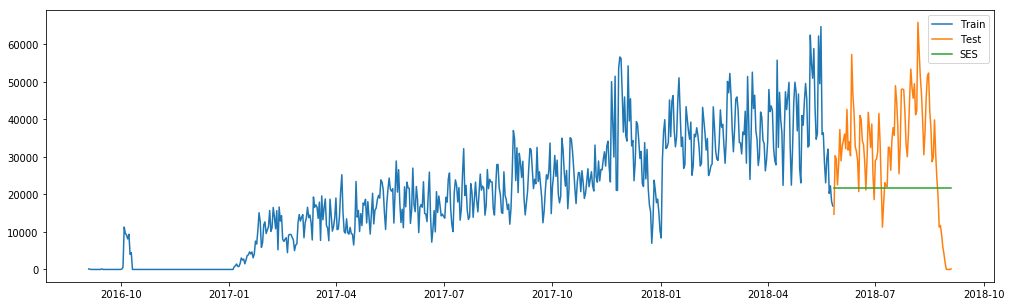

In [71]:
#Plot the data
rcParams['figure.figsize'] = 17, 5
plt.plot(train['Total Price'], label='Train')
plt.plot(test['Total Price'], label='Test')
plt.plot(y_hat['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [72]:
#Calculate rmse
rmse = sqrt(mean_squared_error(test['Total Price'], y_hat.SES))
print(rmse)

17402.473134366002


In [74]:
#Calculate mae
mae = mean_absolute_error(test['Total Price'], y_hat.SES)
print(mae)

14885.45052998217


### Method 3 – Holt’s Linear Trend method

If we use any of the above methods, it won’t take into account this trend. Trend is the general pattern of prices that we observe over a period of time. In this case we can see that there is an increasing trend.
Hence we use Holt’s Linear Trend method that can map the trend accurately without any assumptions.

Smooting level 0.31856815407501854
Smoothing slope 0.0


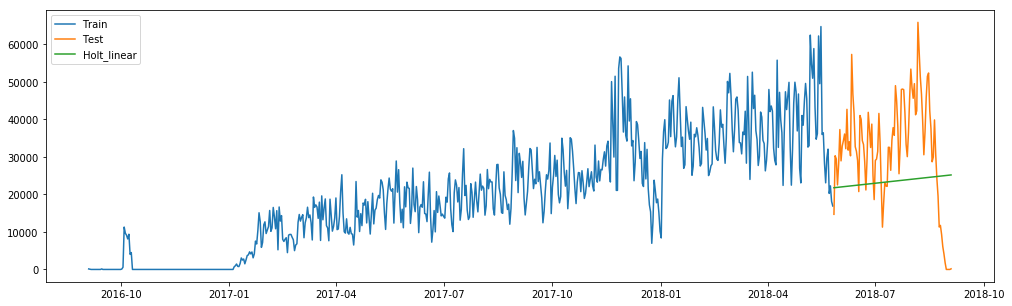

In [75]:
#Holt-Linear model
fit2 = Holt(np.asarray(train['Total Price'])).fit()
y_hat['Holt_linear'] = fit2.forecast(len(test))
print("Smooting level", fit2.model.params['smoothing_level'])
print("Smoothing slope",fit2.model.params['smoothing_slope'])
#Plot the result
rcParams['figure.figsize'] = 17, 5
plt.plot(train['Total Price'], label='Train')
plt.plot(test['Total Price'], label='Test')
plt.plot(y_hat['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [79]:
#Calculate rmse
rmse = sqrt(mean_squared_error(test['Total Price'], y_hat.Holt_linear))
print(rmse)

16556.50211081757


In [80]:
#Calculate mae
mae = mean_absolute_error(test['Total Price'], y_hat.Holt_linear)
print(mae)

14058.411166558843


If we observe closely, there are spikes in sales in middle of the month.

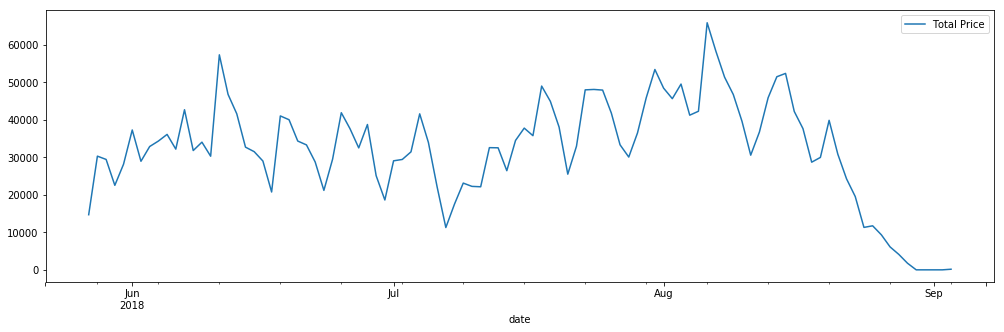

In [81]:
data.tail(100).plot()

### Method 4 : Holt-Winters Method

Datasets which show a similar set of pattern after fixed intervals of a time period have from seasonality.
Hence we need a method that takes into account both trend and seasonality to forecast future prices. 
One such algorithm that we can use in such a scenario is Holt’s Winter method. The idea behind triple exponential smoothing(Holt’s Winter) is to apply exponential smoothing to the seasonal components in addition to level and trend.

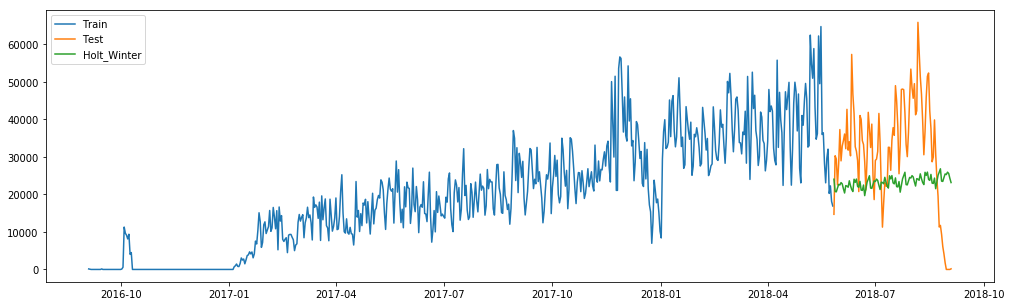

In [83]:
#Fit model
fit3 = ExponentialSmoothing(np.asarray(train['Total Price']) ,seasonal_periods= 30, trend='add', seasonal='add').fit()
y_hat['Holt_Winter'] = fit3.forecast(len(test))
#Plot the data
rcParams['figure.figsize'] = 17, 5
plt.plot( train['Total Price'], label='Train')
plt.plot(test['Total Price'], label='Test')
plt.plot(y_hat['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [84]:
#Calculate rmse
rmse = sqrt(mean_squared_error(test['Total Price'], y_hat.Holt_Winter))
print(rms)

15457.439606224916


In [93]:
#Calculate mae
mae = mean_absolute_error(test['Total Price'], y_hat.Holt_Winter)
print(mae)

14214.30484223988


### Conclusion:

   |        Method              |     RMSE     |    MAE        |
   | --- | --- | --- |
   |Moving Average              |   15457.43   |  11707.52     |
   |Simple Exponential Smoohing |   17402.47   |  14885.45     |
   |Holt Linear                 |   16556.50   |  14058.41     |
   |Holt Winters                |   15457.43   |  14214.30     | 
   
By comparing above methods, we get good results from Moving average model as both RMSE and MAE is smaller compared to others.
Next best model would be Holt Winters. We can conclude that our data does not have good seasonality, trend and is mostly dependent on previous values.
However, we already implemented a method using LSTM to use previous values to predict sales.
So far these problems are noticed:
   1. This dataset ranges from Sepember 2016 to September 2018.
   2. This is small time range, furthermore, data does not show any seasonality. E.g. In 2017 November sales have spiked but there is no data for November and December in 2016.
   3. From 2016 to 2017, sales increased exponentially, but after 2017 growth is linear.
   4. Data points are not consistant: Some days/ weeks/ months don't have any sales
    
So we have 2 conclusions:
1. Future values are highly dependent on previous values
2. Sales are random or time series is not stationary.

A solution to this problem will be discussed in Approach 3:Use Defferencing method with LSTM

**This notebook is MIT liscenced(Added in github repository) https://opensource.org/licenses/MIT <br>
Referance: https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/**